In [1]:
import os, sys, pickle
import numpy as np
import pandas as pd
import product_fem as pf
import fenics
import json
from PIL import Image
from scipy import interpolate

In [2]:
import matplotlib.pyplot as plt

In [3]:
# load spatial and genetic data
simbase = os.path.join("test", "out_2854726128256")
basedir = f"{simbase}_stats"
basename = os.path.join(basedir, "rep676708")
mapfile = f"{simbase}.spstats.csv"
with open(os.path.join(basedir, "params.json"), "r") as pfile:
    params = json.load(pfile)
    for k in params:
        if len(params[k]) == 1:
            params[k] = params[k][0]
spatial_data = pd.read_csv(f"{basename}.stats.csv", index_col=0)
genetic_data = pd.read_csv(f"{basename}.pairstats.csv", index_col=0)
bias_map = Image.open(params['BIAS_MAP_FILE'])
cov_map = Image.open(params['COVARIANCE_MAP_FILE'])
habitat_map = Image.open(params['HABITAT_MAP_FILE'])
empirical_maps = pd.read_csv(mapfile)
width, height = bias_map.width / params['MAP_RESOLUTION'], bias_map.height / params['MAP_RESOLUTION']
aspect_ratio = width/height
size = (width + height)/2

In [4]:
params

{'BIAS': 0.0,
 'BIAS_MAP_FILE': 'maps/one.png',
 'COVARIANCE_MAP_FILE': 'maps/identity.png',
 'HABITAT_MAP_FILE': 'maps/butte_height.png',
 'INTERACTION_DISTANCE': 1.0,
 'K': 10,
 'LAMBDA': 3.0,
 'LOGPATH': 'test/out_2854726128256.log',
 'MAP_RESOLUTION': 20,
 'NUMTICKS': 10000,
 'OUTBASE': 'test/out_2854726128256',
 'OUTDIR': 'test',
 'OUTPATH': 'test/out_2854726128256.trees',
 'SIGMA': 1.0,
 'SURVIVAL': 0.9}

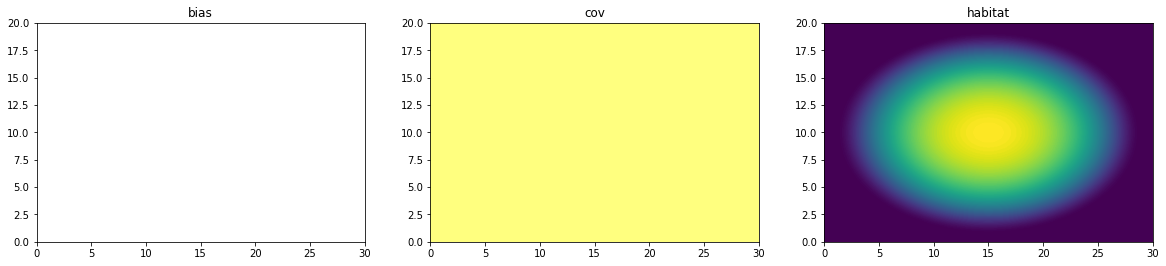

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(20, 9))
for (im, lab), ax in zip(((bias_map, 'bias'), (cov_map, 'cov'), (habitat_map, 'habitat')), axes):
    ax.imshow(im, extent=(0, width, 0, height))
    ax.set_title(lab)

In [6]:
# parameters
penalty = 1.0

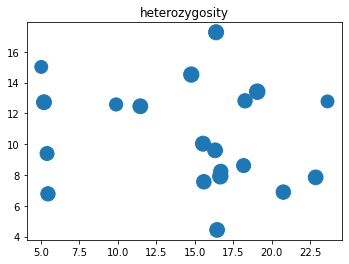

In [7]:
het_scale = 10**(2-np.floor(np.log10(np.max(spatial_data['het']))))
fig, ax = plt.subplots()
ax.scatter(spatial_data['x'], spatial_data['y'], s=spatial_data['het']*het_scale)
ax.set_aspect(1.0)
ax.set_title(f"heterozygosity");

In [8]:
n = 5
mesh = fenics.RectangleMesh(fenics.Point(0.0, 0.0), fenics.Point(width/size, height/size), int(aspect_ratio * n), n)
V = fenics.FunctionSpace(mesh, 'CG', 1)
W = pf.ProductFunctionSpace(V)

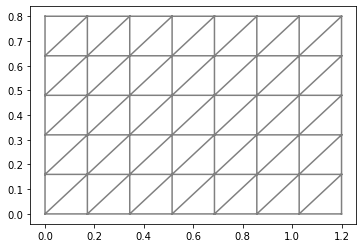

In [9]:
fenics.plot(mesh);

In [10]:
# normalize dxy
train_dxy = genetic_data['dxy'].to_numpy()
train_max_dxy = train_dxy.max()
train_dxy /= train_max_dxy

In [11]:
# pairwise coordinates needed for kernel density estimate
points = spatial_data[['x', 'y']].to_numpy() / size

def coords_to_pairs(points):
    n = len(points)
    N = int(n * (n + 1) / 2)
    xs = np.zeros((N, 2))
    ys = np.zeros((N, 2))
    x1, y1, x2, y2 = [], [], [], []
    for i in range(n):
        for j in range(i, n):
            x1.append(points[:,0][i])
            y1.append(points[:,1][i])
            x2.append(points[:,0][j])
            y2.append(points[:,1][j])

    xs[:,0] = x1
    xs[:,1] = y1
    ys[:,0] = x2
    ys[:,1] = y2
    return xs, ys

In [12]:
# gaussian density estimate on boundary
# TODO: not sure about this
xs, ys = coords_to_pairs(points)
def kernl(x, y):
    x = np.add(x, y) / 2
    def _dists(x_i, x_j, x):
        diffs = x_i - x_j, x_i - x, x_j - x
        dists = np.sum([np.hypot(*xx) for xx in diffs])
        return dists
    dists = np.array([_dists(x_i, ys[i], x) for i, x_i in enumerate(xs)])
    e = 1.0 / size
    scale = 2 * e**2
    return np.exp(-dists / scale)

def boundary(x, y):
    k = kernl(x, y)
    return (train_dxy * k).sum() / k.sum()

In [13]:
eqn = pf.HittingTimes(W, boundary, epsilon=0.03)
control = eqn.control

# loss functionals
reg = {'l2': [100*penalty, 100*penalty], 'smoothing': [penalty, penalty]}
train_sd = pf.SpatialData(train_dxy, points, W)
train_loss = pf.LossFunctional(train_sd, control, reg)

invp = pf.InverseProblem(eqn, train_loss)

In [14]:
options = {'ftol': 1e-8, 
           'gtol': 1e-8, 
           'maxcor': 15,
           'maxiter': 100}
m_hats, losses, results = invp.optimize(control, 
                                        method='L-BFGS-B', 
                                        options=options)

36.428436402493055 3.3783818141869255 32.96671866551068 0.08333592279544562
3.191027407385321 0.6513712960502381 1.8522325480798512 0.6874235632552315
0.725305469941657 0.37339008641517324 0.12012845027355588 0.2317869332529279
0.5275075575425812 0.3215150489886554 0.07119615632398328 0.13479635222994246
0.3805457492633876 0.3296969599082 0.0256972631970051 0.02515152615818244
0.35550633270715043 0.3336941524691946 0.011778918904742473 0.010033261333213365
0.34379033187207525 0.33495156904085077 0.006482762313145516 0.0023560005180789153
0.34255857393972655 0.3349024421632973 0.006304842734005662 0.0013512890424236083
0.3422637404333663 0.33470774284629495 0.0064462157441128815 0.0011097818429584914
0.3421255970125385 0.3346704420151169 0.006470369005309323 0.0009847859921122309
0.3420681228552942 0.3348226835902716 0.006303588959880957 0.0009418503051415969
0.3420611976991497 0.33485537890286377 0.006263474708612367 0.0009423440876735872
0.3420574947714354 0.3348956685265111 0.0062175

In [15]:
control.update(m_hats[-1])
u_hat = eqn.solve()

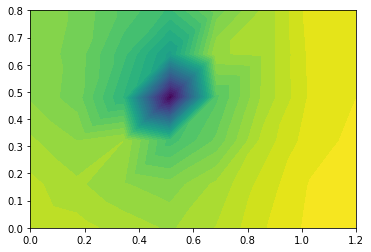

In [16]:
fenics.plot(u_hat.get_slice((0.5, 0.5)));

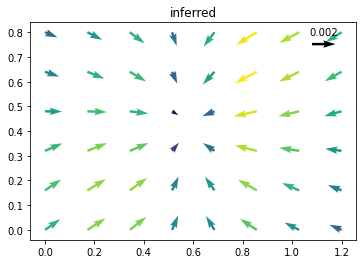

In [17]:
f = control.functions[0]
Q = fenics.plot(f)
fig = Q.figure
ax = fig.axes[0]
ax.set_title("inferred")
ax.quiverkey(Q, 0.9, 0.9, .002, label=f"{.002}", angle=0);

In [18]:
def make_map_fn(sp, n):
    xvals = np.unique(sp['x'])
    yvals = np.unique(sp['y'])
    nr, nc = len(xvals), len(yvals)
    X = sp['x'].to_numpy().reshape((nr, nc))
    for i in range(nr):
        assert len(np.unique(X[i,:])) == 1
    Y = sp['y'].to_numpy().reshape((nr, nc))
    for j in range(nc):
        assert len(np.unique(Y[:,j])) == 1
    Z = empirical_maps[n].to_numpy().reshape((nr, nc))
    return interpolate.RegularGridInterpolator((xvals, yvals), Z)

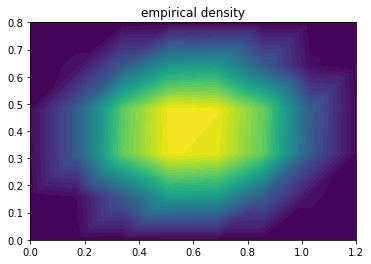

In [19]:
density_fn = make_map_fn(empirical_maps, 'density')
density = pf.transforms.callable_to_Function(lambda x, y: density_fn([[x * size, y * size]]), V)
fenics.plot(density).axes.set_title("empirical density");

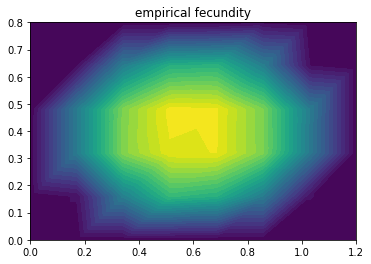

In [20]:
fecundity_fn = make_map_fn(empirical_maps, 'fecundity')
fecundity = pf.transforms.callable_to_Function(lambda x, y: fecundity_fn([[x * size, y * size]]), V)
fenics.plot(fecundity).axes.set_title("empirical fecundity");

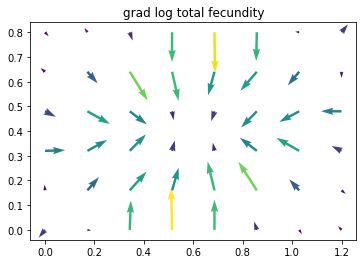

In [21]:
log_total_fecundity = density.copy()
log_total_fecundity.vector()[:] = np.log(0.1 + density.vector()[:] * fecundity.vector()[:])
grad_log_total_fecundity = fenics.project(fenics.grad(log_total_fecundity))
fenics.plot(grad_log_total_fecundity).axes.set_title("grad log total fecundity");

In [40]:
def rgb_to_floats(x, min=-1, max=1):
    """ The "inverse" of floats_to_rgb. Note the denominator is 255, mirroring SLiM. """
    out = min + (max - min) * np.array(x).astype('float') / 255
    return out

def image_fn(im, x, y, min=-1, max=1):
    u = x * params['MAP_RESOLUTION'] * (1 - 1/im.width)
    v = (im.height - y * params['MAP_RESOLUTION']) * (1 - 1/im.height)
    z = im.getpixel((u, v))
    return rgb_to_floats(z, min=min, max=max)

In [41]:
bias = pf.transforms.vectorized_fn(V, dim=2, name='bias')
bias.vector()[:] = pf.transforms.callable_to_array(
    lambda x, y: params['BIAS'] * image_fn(bias_map, x * size, y * size)[:2],
    V,
).flatten()

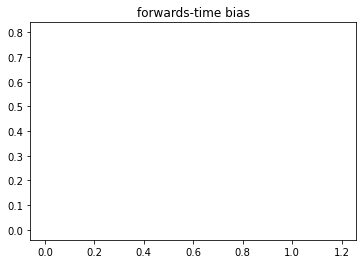

In [43]:
fenics.plot(bias).axes.set_title("forwards-time bias");

Object cannot be plotted directly, projecting to piecewise linears.


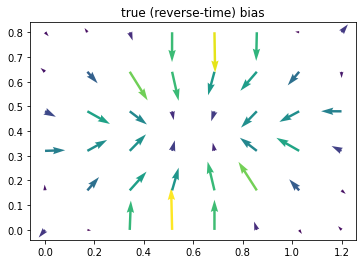

In [44]:
true_bias = grad_log_total_fecundity - bias
fenics.plot(true_bias).axes.set_title("true (reverse-time) bias");